# Ensemble Kalman Filter Workflow

1. Available observation vector for $\vec{y_{k+1}}$, and calculate the observation ensemble from the directional uncertainties based on the wind speed and direction. To calculate the uncertainty for each point of the perimeter:
    1. Obtain the centroid $c_k = 1/M\sum{y_k}$ where $M$ is the number of points.
    2. Calculate vectors $\vec{v_k^m}$ for each point from the centroid to the point where $m$ is the $m^{th}$ point in the perimeter
    3. Obtain the wind speed and direction: $\vec{u_k}$ from the closest weather station to the centroid
    4. Uncertainty for each point $m$ is then $e_k^m = \alpha \left(1 - \vec{v_k^m} \cdot \vec{u_k}\right)$

2. Given a state vector $x_k$ and uncertainties around each point $P_k$, generate an ensemble 
$$X_k = (x_k^1, x_k^2, \cdots , x_k^N)$$
    1. For the first timepoint $k=0$, the state vector is the first observation $(x_0 = y_0)$, and the ensemble is obtained from directional uncertainties assigned based on the wind speed and direction
    2. **Question:** When creating the ensemble, do we preserve the mean $\overline{x_k}$?
    
3. From the ensemble $X_k$, advance for each state vector $X_{k+1} = F(X_k, u_k)$, where $u_k$ 

4. 

## Dependencies:

In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

## Default Values

In [2]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

## Select a fire

```selected_fire``` variable holds the name of the fire selected. ```selected_fire = 'Maria2019'``` for now

In [3]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

unique_desc = usr.db.gdfignitionAll['description'].unique()
print(f'Available fires are {unique_desc}')

selected_fire = SELECTED_FIRE_DEFAULT
print(f'{selected_fire} is selected.\n')
if (unique_desc == selected_fire).any():
    print(f'{selected_fire} is found!')
else:
    raise ValueError(f'{selected_fire} not found in possible fire descriptions: {unique_desc}')

Database interaction not yet implemented. Use pickle file for dataframes instead!
Available fires are ['Maria2019' 'River2021' 'Bridge2021']
Maria2019 is selected.

Maria2019 is found!


In [4]:
referenceidx_lst = [usr.db.gdfignition.index[0]] + usr.db.gdfignition.index[-12:].tolist()

In [5]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]
    

class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        
        if isinstance(geom, MultiPolygon):
            geompoly = calculate_max_area_geom(geom)
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)
    
    

In [6]:
def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        # randx = random.gauss(mu, sigma)
        # randy = random.gauss(mu, sigma)
        
        # Choose a normal random radius based on the given sigma
        radius = abs(random.gauss(mu, sigma))
        
        # Calculate x and y distance for the random
        randx = radius*np.cos(theta)
        randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    # return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    return Polygon(sampled_vertices)


def interpolate_geometries(geoms, vertex_count = None):
    
    if vertex_count == None:
        vertex_count = 0
        for geom in geoms:
            if isinstance(geom, MultiPolygon):
                geom = calculate_max_area_geom(geom)

            if vertex_count < len(geom.exterior.coords):
                vertex_count = len(geom.exterior.coords)

    interpolated_vertices = []
    for geom in geoms:
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)
        
        geom_state = State(geom)
        vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))

        interpolated_vertices.append(vertices)
        
    return interpolated_vertices


def align_vertices(interpolated_vertices):

    time_estimator = TimeEstimator(len(interpolated_vertices)-1)

    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        print(time_estimator.info_str(i), end='\r', flush=True)

        right_vertices = interpolated_vertices[i+1]


        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices)-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices
## Check reverse direction too?

def create_ensembles(nsamples, current_state, windspeed, winddirection, normalized_scale, filetype, objectid, datetime, description):
                     
    # uncertainty in both x and y for each vertex
    # uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=windspeed*normalized_scale)*np.sqrt(current_state.lengths.sum())
    uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=1)

    ignitions = {'igniteidx': [], 
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'datetime': [],
                 'description': [],
                 'geometry': []}

    time_estimator = TimeEstimator(nsamples)
    for sample in range(nsamples):
        print(time_estimator.info_str(sample), end='\r', flush=True)
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}E{sample:04d}')

        geometry = sample_geometry(current_state, uncertainties)
        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{selected_fire}E{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
        
    return ignitions


def create_ensemble_matrix(geoms, vertex_count=None, aligned_geom=None):

    interpolated_vertices = interpolate_geometries(geoms, vertex_count=vertex_count)
    # Add first list of vertices from the state vector to align. align_vertices aligns all the perimeters w.r.t the first array
    if aligned_geom is not None:
        interpolated_vertices = [aligned_geom] + interpolated_vertices

    aligned_vertices = align_vertices(interpolated_vertices)
    if aligned_geom is not None:
        aligned_vertices = aligned_vertices[1:]
    else:
        aligned_geom = aligned_vertices[0]
    
    if vertex_count is None:
        vertex_count = aligned_vertices[0].shape[0]
    
    X = np.zeros((vertex_count*2, nsamples))
    for i, vertices in enumerate(aligned_vertices):
        X[:,i] = vertices.flatten()
        
    return X, aligned_geom, vertex_count


def state_to_ignitions(X_0, objectid_lst, datetime_lst, description_lst, filetype_lst, usr):

    geoms = [Polygon(zip(X_0[::2,i], X_0[1::2,i])).buffer(0) for i in range(X_0.shape[1])]

    ignitions = {'igniteidx': [],
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'geometry': [],
                 'datetime': [],
                 'description': []}

    for sample, geometry in enumerate(geoms):
        filetype = filetype_lst[sample]
        datetime = datetime_lst[sample]
        description = description_lst[sample]
        objectid = objectid_lst[sample]
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}U{sample:04d}')

        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{description}U{sample:04d}_{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
    
    return ignitions

### Plotting functions

In [7]:
def compare_perimeters(alst, colors='rgbcmyk', showvertex = 0):
    fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for a,c in zip(alst, colors):
        if c == 'r':
            ax.plot(a[::2], a[1::2], c+'o', markersize=1)
        else:
            ax.plot(a[::2], a[1::2], c)
            
        ax.scatter(a[2*showvertex], a[2*showvertex + 1], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    ax.set_ylim(1.502e6, 1.506e6)
    ax.set_xlim(-2.087e6, -2.081e6)
    
def compare_matrices(X, colors='rgbcmy', showvertex = 0, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for i in range(X.shape[1]):
        c = colors[i%len(colors)]
        ax.plot(X[::2,i], X[1::2,i], c)
        ax.scatter(X[2*showvertex,i], X[2*showvertex+1,i], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    # ax.set_ylim(1.502e6, 1.506e6)
    # ax.set_xlim(-2.087e6, -2.081e6)
    
    return ax

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    ax.plot(X_mean[::2], X_mean[1::2], color=color)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)

In [8]:
class EnKF:
    # Initialize with the first observation
    # Windspeed and direction is given from PyLaski
    def __init__(self, observation: gpd.GeoSeries, windspeed: int, winddirection: int, normalized_scale: float, nsamples: int, usr: futils.User):
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        
        
        self.state_datetime = observation['datetime']
        self.selected_fire = observation['description']
        self.igniteidx = observation.name
        self.current_state = State(state_geom)
        
        
        self.windspeed = windspeed
        self.winddirection = winddirection
        self.normalized_scale = normalized_scale
        self.nsamples = nsamples
        self.usr = usr

        self.ignitions = create_ensembles(self.nsamples, self.current_state, self.windspeed, self.winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])
        
        self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))
        
        # Create ensemble matrix
        self.X_0, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.ignitions['geometry'])
        
    # Updates the state matrix
    # Need to first add the observation into the database (usr.db for now)
    def update(self, compareidx: str, lcpidx: str, barrieridx: str, observation: gpd.GeoSeries, windspeed: int, winddirection: int):
        # Advance the state in Farsite using the windspeed and direction
        inputData_lst = []
        mainapi_lst = []
        for igniteidx in self.ignitions['igniteidx']:
            inputData = {'description': self.selected_fire,
                         'igniteidx'  : igniteidx,
                         'compareidx' : compareidx,
                         'lcpidx'     : lcpidx,
                         'barrieridx' : barrieridx,

                         'windspeed': self.windspeed, 'winddirection': self.winddirection,
                         'relhumid': 90, 'temperature': 20}

            mainapi_lst.append(self.usr.calculatePerimeters(inputData))
            

        # from multiprocessing import Pool

        # numproc = 4
        # pool = Pool(processes=numproc)

        # Run for each FarsiteManual
        for mainapi in mainapi_lst:
            # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
            mainapi.run_farsite()

        # pool.close()
        # pool.join()
        
        # Filter igniteidx->compareidx simulations only
        df = self.usr.db.gdfsimulation
        filtered_indices = df[df['igniteidx'].isin(self.ignitions['igniteidx']) & (df['compareidx'] == compareidx)].index
        
        self.Xt_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(df.loc[filtered_indices, 'geometry'], 
                                                                                 self.vertex_count, self.aligned_geom)
        
        
        
        # Calculate ensemble for the observation
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        # igniteidx = observation.name
        state_datetime = observation['datetime']

        self.observed_state = State(state_geom)

        self.observed_ensemble = create_ensembles(self.nsamples, self.observed_state, windspeed, winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])

        self.Y_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.observed_ensemble['geometry'], self.vertex_count, self.aligned_geom)
        
        ##############################
        # Calculate the Kalman Filter
        ###############################
        neighbor_count = 0
        invert = False
        normed = False

        xt_1 = self.Xt_1.mean(axis=1, keepdims=True)
        y_1 = self.Y_1.mean(axis=1, keepdims=True)

        Ex_1 = self.Xt_1 - xt_1.repeat(self.nsamples, axis=1)
        Ey_1 = self.Y_1 - y_1.repeat(self.nsamples, axis=1)


        connectivity = np.eye(2*self.vertex_count, k=0)
        for i in range(neighbor_count):
            connectivity += np.eye(2*self.vertex_count, k=2*(i+1)) + np.eye(2*self.vertex_count, k=-2*(i+1))


        Py_1 = 1/(nsamples-1)*np.matmul(Ey_1, Ey_1.T)*connectivity
        Pxy_1 = 1/(nsamples-1)*np.matmul(Ex_1, Ey_1.T)*connectivity

        if normed:
            max_Py = abs(Py_1).max()
            max_Pxy = abs(Pxy_1).max()

            Py_1 /= max_Py
            Pxy_1 /= max_Pxy
        
        if invert:
            Py_1inv = np.linalg.pinv(Py_1, hermitian=True)
        else:
            Py_1inv = np.zeros_like(Py_1)
            np.fill_diagonal(Py_1inv, 1/Py_1.diagonal())

        assert(np.allclose(np.matmul(Py_1inv, Py_1), np.eye(2*self.vertex_count))), 'Inverse calculation is incorrect'

        self.K = np.matmul(Pxy_1, Py_1inv)
        
        #### Update the state ensemble
        self.X_1 = self.Xt_1 + np.matmul(self.K, (self.Y_1 - self.Xt_1))
        
        ####################
        # Recursive updates
        ##################
        
        # Update ignitions
        self.X_0 = self.X_1
        self.ignitions = state_to_ignitions(self.X_0, self.observed_ensemble['objectid'], self.observed_ensemble['datetime'], 
                           self.observed_ensemble['description'], self.observed_ensemble['filetype'], self.usr)
        
        self.current_state = self.observed_state
        
        self.usr.db.gdfignition = pd.concat([self.usr.db.gdfignition, gpd.GeoDataFrame(self.ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])
        
        # x_1 = X_1.mean(axis=1, keepdims=True)
        
# ## obtain the igniteidx of the ignition
# ## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
# compareidx = '9f82e870591748a9a8a01346d174f2a1'    # t=1 observation
# lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
# barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index        

In [9]:
def calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model):
    inputData = {'description': 'Maria2019',
                 'igniteidx'  : igniteidx_lst[-1],
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr_model.calculatePerimeters(inputData)
    mainapi.run_farsite()

    gdfsim = usr_model.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)
    
    usr_model.db.gdfignition = pd.concat([usr_model.db.gdfignition, gpd.GeoDataFrame({'filetype': 'Ignition',
                                                                                      'objectid': str(usr_model.db.gdfignition.loc[gdfsim['igniteidx']]['objectid']) + '_farsite',
                                                                                      'filepath': gdfsim['filepath'],
                                                                                      'datetime': gdfsim['datetime'],
                                                                                      'description': gdfsim['description'],
                                                                                      'geometry': gdfsim_geom}, index=[gdfsim.name])
                                         ])
    igniteidx_lst.append(gdfsim.name)
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                     crs='EPSG:5070').to_file(gdfsim['filepath'])

In [10]:
referenceidx_lst

['f23196b034474744bdca7df94b13e0f7',
 '51fdaebe31f44ad69272779a3f01182d',
 '68b265e5ba78410d9ba23e595c4ebe4d',
 'aab698d3dcdb40c5a200fa962062eac6',
 '898b0f9313d44e70bfe3fd53a269981f',
 'f812b5bd6b9841c7a9d3c049f2ef65d0',
 '1902f9bb87654d6596616ce39baa5bd4',
 '8a431825f5ed4c80a5c8bbe6272aae75',
 'eaf6ac2e01c14ee6a7575004cc255470',
 '2a2d3f9489a34a5ebe7acb1842be28b9',
 'a966c3e028054453ae6ae791bdbb2eaa',
 '4589feb89833462392177adc46d432b2',
 'b93e051584c54d3183511baf8088fc84']

In [11]:
# Initial params

initial = usr.db.gdfignition.iloc[0]
windspeed = 10   # Calculations are made with windspeed = 10, winddirection = 90
winddirection = 60
nsamples = 100
normalized_scale = 2

state = EnKF(initial, windspeed, winddirection, normalized_scale, nsamples, usr)
X_0_lst = [state.X_0]

usr_model = futils.User(fp)
# igniteidx_lst = ['f23196b034474744bdca7df94b13e0f7']
igniteidx_lst = [referenceidx_lst[0]]

/tmp/ipykernel_2383/804870336.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))


Database interaction not yet implemented. Use pickle file for dataframes instead!


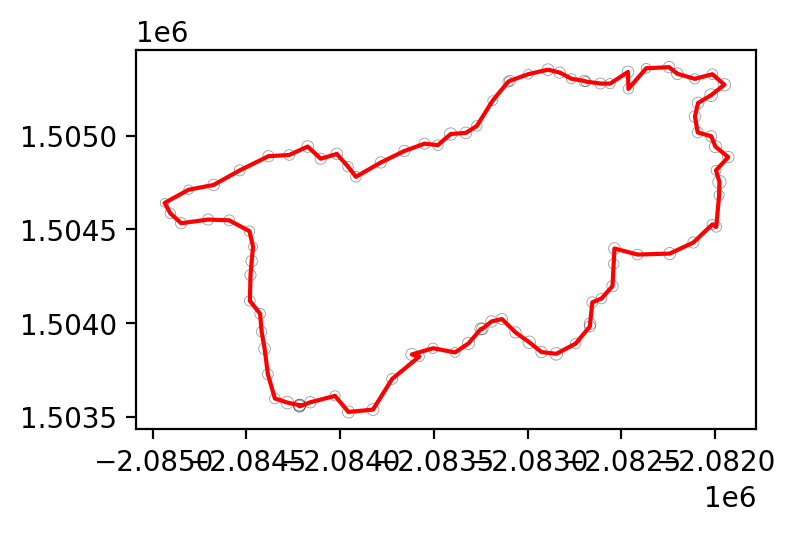

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
ax.set_aspect('equal')

In [13]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

# observation = usr.db.gdfignition.iloc[1]
observation = usr.db.gdfignition.loc[referenceidx_lst[1]]
compareidx = observation.name    # t=1 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
X_0_lst.append(state.X_0)

calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)

{'description': 'Maria2019', 'igniteidx': '4da296adade24d42906823ea2dc96ab7', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '97b193bc549041ff8f7f3f671f5ce6d3', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'ccef981d8db44b48a301645041f28c3b', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00304/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E97b193bc549041ff8f7f3f671f5ce6d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00304/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00305/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eccef981d8db44b48a301645041f28c3b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00305/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00306/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec56bdc6d9ed14db39ce0a608c6b4f472.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00306/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00307/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebafc830f4fe54f85ae456e7a17ee0b36.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00307/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00308/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5407eb32b91e4333ac4a10fe414643b0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00308/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00309/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef4922ec7cd654f14bdd08723ad876324.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00309/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00310/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E05b5765b672d4e34bd2926144b17f3da.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00310/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00311/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb2bc688c3d824a5fbb39c94ac07c913d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00311/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00312/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E576647f3a9a3426d8c8d86e5480b4266.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00312/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00313/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef7842aecd2fc4edf92391b90f37efca3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00313/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00314/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3c9ab7a9a02a47419e4acfa97fb1e1d9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00314/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00315/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3fe1639472814f2097f549c1e92a4d87.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00315/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00316/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee5ad14e43fe34633853b6589c8aaa65a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00316/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00317/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E24d10e6b0a5343cc8e181e57b40db1af.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00317/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00318/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed37ea423b9064efe92c93e879ee0e03d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00318/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00319/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E671c0c11d3084bd6b13e42bdc91e0a4f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00319/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00320/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb24e93759a7849d7be0b2def7468ce5a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00320/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00321/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E26da9c0ed4514866b54b0bbddc6cf3ce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00321/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00322/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9f7efa2234614a608e19fd51a186b5cc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00322/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00323/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea455e0dc93694af6b1209721b50e2c9d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00323/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00324/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E89858808ccb946a8acce6d935eefb0b0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00324/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00325/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E541de5ad43c6477199670ea3b1082535.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00325/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00326/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5578ebf95a5649108a121d09cf69879b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00326/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00327/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E09cd472b6550486c87e04617a5274e14.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00327/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00328/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea932f06718294de9873cc4fa947839b8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00328/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00329/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E36f2044be4d14eae9b46d007f0fbd351.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00329/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00330/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eab5e05822b824901bade0663dd03ca53.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00330/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00331/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4d933fef094c44ae9a252831a04bfb08.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00331/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00332/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2e32dcec3f924bea8dd8007410e06d9a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00332/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00333/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2f97822e53ce4753b0fc1b5500345187.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00333/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00334/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E652226631edf4795b50a2cdb5f93b1f4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00334/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00335/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed46c8303491e4dcc881351d1932aeff7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00335/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00336/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9775728483da4a61a62678e833a8baa3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00336/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00337/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecd447dd8494c4bc6973cd696c754f353.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00337/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00338/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9286a74f06fb4519abba9924297f4527.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00338/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00339/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef91a3597edf449d28b1e5ecb072accc1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00339/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00340/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E365241500bb147549dde0a0931cc2f49.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00340/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00341/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9a6d396da2534b139d06c4bdbf5e8644.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00341/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00342/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0d561fdf683f44ecb00612a67648e65b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00342/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00343/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef4d43a37ad7b443192905707094c06be.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00343/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00344/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9eba62db3fbc4a24901c7d95f6008bbd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00344/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00345/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9c6206c0fd5c4f3081b9e743866d198e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00345/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00346/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5f9c1cb6b8794866951cf4c30f189da5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00346/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00347/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1120ebe84e6344d3a416549e344bad7a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00347/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00348/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5604ef46ff554d18b3aaaa5e81203b38.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00348/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00349/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef17da10978ef4b9e909454cd48e9a64d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00349/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00350/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E97513a964be645f986d3c9c332c1219a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00350/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00351/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E537d1119d11749d4a955b1be3384d4f8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00351/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00352/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E69ee7ce802c248468a14842dace08c15.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00352/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00353/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eed1b9a020a584a57b7b0360b88ce92cb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00353/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00354/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4063ce4de8a54661bc2641d8a778f9bc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00354/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00355/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edb318529e63443f79d4fa992004ce305.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00355/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00356/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed3ba42caccbf4a1daf5a3ea92553bb84.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00356/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00357/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8457cdc5bcbe476881b9bab9bf8bdf42.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00357/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00358/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E690ab3372dc642c3b1c6f583f77c3b0a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00358/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00359/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea910eb34625841c9a142cc2253331c32.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00359/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00360/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef1356cdb64364e40bc552d19418431f9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00360/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00361/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E39e42872adda469db56148619bf90cc9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00361/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00362/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E82c75824df24449fb327e0ca6be8c7ac.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00362/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00363/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E13a6a251d0cd4893892859f2f7a3b336.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00363/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00364/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E82ff1a5a4dab47f8b15d758d41ce07e3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00364/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00365/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef44daade68b24cff9b6d9db790122401.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00365/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00366/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E16c1ee473da843928d9ea6a9a77b7cd2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00366/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00367/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E47a53cab092341328756e99dea1eb03c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00367/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00368/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3b341ccd6a2f4dc995acd4e92ae6b6b6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00368/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00369/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4937d489c72a4e068086272767175c6c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00369/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00370/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E61766108d0c247b9bd1881656daae430.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00370/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00371/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef88e9e7b8b4f44b6842d289f4fb8e342.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00371/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00372/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E53019b11250c42a5ac0be7c3528c47c9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00372/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00373/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E308db7245ee543a5823c9295db1d76c0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00373/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00374/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E57075c5300644f4ba3b3fbb06badd950.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00374/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00375/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E31cc5cc8786a4abf8ada998642d23f7b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00375/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00376/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E29d618f962174196bd21d3016a4bc6b8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00376/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00377/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4cbf2c69890943feaac1c1ae604a048c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00377/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00378/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eebb9470914d94ac9ba879b2fb4ad2fe1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00378/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00379/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed1fb6ed0ba954fd5a07e01699b6cac11.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00379/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00380/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef4402e62cbf243b38ae2428d8cc7be32.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00380/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00381/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb8f083f26dc245e89becf32ba664922a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00381/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00382/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee80e5e09722f4314aff28a0085e6bfcb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00382/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00383/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4da4aef5e93a44aaa03adf7289ceb7d7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00383/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00384/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0e4cd0f7b22e4000a378787021e062fe.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00384/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00385/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E737ff42e75ff41c5ad79f91375c238ed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00385/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00386/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec51cc0610c2e47fc9208766fae307a37.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00386/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00387/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea799a3b8497e4bac8f96a033dab70799.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00387/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00388/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E90f57e21f5864df49a9f738e401aaf23.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00388/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00389/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E80137aea3b68414999cddef774905f00.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00389/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00390/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edb444173143844aabd51b8f4984838be.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00390/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00391/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb0a9c77f6a4740bb9070fde349afcbb5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00391/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00392/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecb5346d7b3f947d5b89a13c8cf337eaf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00392/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00393/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9c1ff53e7fbc4e7ca62d4ec9f4664047.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00393/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00394/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E93ccc2eeaa704b2fad03b7896ecef90d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00394/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00395/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3b4abb67362b4b918b7d875572ae51b8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00395/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00396/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7817cf7c00dd4054a382326161210709.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00396/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00397/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E369dd89d8276497aa8f01b601ca9a7c7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00397/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00398/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9b397826883b46378a6962571ea9e3de.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00398/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00399/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed0a39a6877454b27b712a3c5879982d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00399/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00400/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2848d300a94948be8121036bf7779349.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00400/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00401/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9a717945b84c4f6a8c8a1df547e9abca.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00401/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00402/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef5744ac417d94440ab61857868c80734.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00402/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230216/Run_00403/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230216/Run_00403/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


In [ ]:
state.X_0

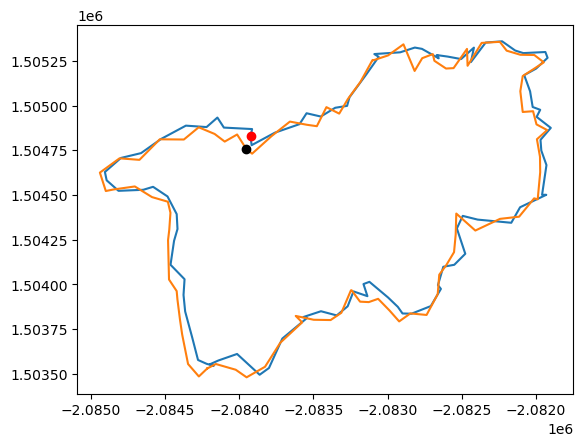

In [23]:
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
# ax.set_aspect('equal')

plt.plot(X_0_lst[0][::2, 0], X_0_lst[0][1::2, 0])
plt.plot(X_0_lst[0][50, 0], X_0_lst[0][51, 0], 'ro')

plt.plot(X_0_lst[0][::2, 50], X_0_lst[0][1::2, 50])
plt.plot(X_0_lst[0][50, 50], X_0_lst[0][51, 50], 'ko')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# # plot_matrix(X_0_lst[0], ax=ax, color='red', ls='-')
# plot_matrix(X_0_lst[1], ax=ax, show_stdev=True, color='blue', ls='--')
# ax.set_aspect('equal')
k = 1
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in [0,5,10,15,20,25,50]:
    ax.plot(X_0_lst[k][::2, i], X_0_lst[k][1::2, i])

In [ ]:
%%time

# calc_range = range(2,10)
time_estimator = TimeEstimator(len(calc_range))
for i in calc_range:
    print(time_estimator.info_str(i))
    observation = usr.db.gdfignition.iloc[i]
    compareidx = observation.name    # t=1 observation

    state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
    X_0_lst.append(state.X_0)

    calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)
    
igniteidx_lst_model = igniteidx_lst.copy()

In [ ]:
# import geopandas as gpd

# gdf = gpd.read_file('/home/jovyan/data/ignitions/Maria2019U0081_f5421b23173641e18b5d780c6d528798.shp')
# gdf['geometry'][0]

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

# # plot_matrix(X_0_lst[0], ax)
# # plot_matrix(X_0_lst[1], ax, color='blue')
# plot_matrix(X_0_lst[0], ax, color='black')
# plot_matrix(X_0_lst[1], ax, color='black')
# plot_matrix(X_0_lst[2], ax, color='black')
# plot_matrix(X_0_lst[3], ax, color='black')
# plot_matrix(X_0_lst[4], ax, color='black')
# plot_matrix(X_0_lst[5], ax, color='black')
# plot_matrix(X_0_lst[6], ax, color='black')
# plot_geometry(usr.db.gdfignition.iloc[4]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[5]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[6]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[10]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[11]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[12]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[13]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[14]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[15]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[16]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[17]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[18]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[0]['geometry'], ax)

## Compare the predictions from the updated states, observations and using only the first simulation

### 1. Predict with the updated states

In [ ]:
usr_combined = futils.User(fp)
igniteidx_lst = []
compareidx_lst = []
for i, X_0 in enumerate(X_0_lst):
    obrow = usr.db.gdfignition.iloc[i]
    comprow = usr.db.gdfignition.iloc[i+1]
    
    vertices = X_0.mean(axis=1)
    geom = Polygon(zip(vertices[::2],vertices[1::2])).buffer(0)
    
    dt = obrow['datetime']
    desc = obrow['description']
    objid = str(obrow['objectid']) + '_updated'
    ftype = obrow['filetype']
    
    ignitions = state_to_ignitions(X_0.mean(axis=1, keepdims=True), [objid], [dt], [desc], [ftype], usr_combined)
    igniteidx_lst.append(ignitions['igniteidx'][0])
    compareidx_lst.append(comprow.name)
    
    usr_combined.db.gdfignition = pd.concat([usr_combined.db.gdfignition, gpd.GeoDataFrame(ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])

In [ ]:
igniteidx_lst_observed = []
compareidx_lst_observed = []
for i in range(len(igniteidx_lst)):
    igniteidx_lst_observed.append(usr_combined.db.gdfignition.index[i])
    compareidx_lst_observed.append(usr_combined.db.gdfignition.index[i+1])

In [ ]:
# Combine all igniteidx and compareidx into a single

igniteidx_lst_combined = igniteidx_lst + igniteidx_lst_observed
compareidx_lst_combined = compareidx_lst + compareidx_lst_observed

desc_lst_combined = ['Maria2019_updated' for i in range(len(igniteidx_lst))] + ['Maria2019_observed' for i in range(len(igniteidx_lst))]
inputData_lst = []
mainapi_lst = []
for (igniteidx, compareidx, desc) in zip(igniteidx_lst_combined, compareidx_lst_combined, desc_lst_combined):
    inputData = {'description': desc,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : '43b7f5db36994599861eec4849cc68fd',
                 'barrieridx' : 'cb47616cd2dc4ccc8fd523bd3a5064bb',
                 
                 'windspeed': 10, 'winddirection': 60,
                 'relhumid': 90, 'temperature': 20}
    
    mainapi_lst.append(usr_combined.calculatePerimeters(inputData))
    
for mainapi in mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()

In [ ]:
# usr_combined.db.gdfignition.to_pickle('/home/jovyan/ignitions.pkl')
# usr_combined.db.gdfsimulation.to_pickle('/home/jovyan/simulations.pkl')

#### Interpolate all the vertices

#### TODO: Vertices include an additional point when generated from geometry. Remove the repeat!

#### TODO: Check whether the aligned_vertices have the correct roll amount
1. Create matrices from the aligned_vertices, and form the $X_0$ ensemble state matrix
2. Using the observation $y_1$, update the state vector and obtain $X_1$

#### TODO - Question: Can we find a way to not interpolate the vertices
1. Without interpolation, we need to create a matrix that maps the observed vertices to the state vector

## Compare the perimeters

In [ ]:
# gdfignition = pd.read_pickle('/home/jovyan/ignitions.pkl')
# gdfsimulation = pd.read_pickle('/home/jovyan/simulations.pkl')

gdfignition = usr_combined.db.gdfignition
gdfsimulation = usr_combined.db.gdfsimulation

gdfignition_model = usr_model.db.gdfignition
gdfsimulation_model = usr_model.db.gdfsimulation

In [ ]:
def get_coordinates(geom):
    x,y = geom.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    return x,y

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=2000)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

calculate_error = calculate_area_diff

In [ ]:
geoms_updated = []
geoms_observed = []
geoms_compare = []
geoms_model = []
errors_updated = []
errors_observed = []
errors_model = []
dt = []

for compareidx in compareidx_lst[:-1]:
    gdffiltered = gdfsimulation[gdfsimulation['compareidx'] == compareidx]
    
    geom_updated = gdffiltered[gdffiltered['description'] == 'Maria2019_updated']['geometry'].iloc[0]
    if isinstance(geom_updated, MultiPolygon):
        geom_updated = calculate_max_area_geom(geom_updated)
    geoms_updated.append(geom_updated)
    
    geom_observed = gdffiltered[gdffiltered['description'] == 'Maria2019_observed']['geometry'].iloc[0]
    if isinstance(geom_observed, MultiPolygon):
        geom_observed = calculate_max_area_geom(geom_observed)
    geoms_observed.append(geom_observed)
    
    geom_compare = gdfignition.loc[compareidx, 'geometry']
    if isinstance(geom_compare, MultiPolygon):
        geom_compare = calculate_max_area_geom(geom_compare)
    geoms_compare.append(geom_compare)
    
    gdffiltered_model = gdfsimulation_model[gdfsimulation_model['compareidx'] == compareidx]
    geom_model = gdffiltered_model[gdffiltered_model['description'] == 'Maria2019']['geometry'].iloc[0]
    if isinstance(geom_model, MultiPolygon):
            geom_model = calculate_max_area_geom(geom_model)
    geoms_model.append(geom_model)
    
    dt.append((gdfignition.loc[compareidx, 'datetime'] - gdfignition.iloc[0]['datetime']).total_seconds()/60/60)
    
    errors_updated.append(calculate_error(geom_updated, geom_compare))
    errors_observed.append(calculate_error(geom_observed,  geom_compare))
    errors_model.append(calculate_error(geom_model, geom_compare))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=400)
ax.plot(dt, errors_updated, label='EnKF')
ax.plot(dt, errors_observed, label='Observed')
ax.plot(dt, errors_model, label='Model')

ax.set_xlim(0,6)
ax.set_ylim(0, 2.5e7)

ax.set_xlabel('Hours after first ignition')
ax.set_ylabel('Area difference')

ax.legend()